In [1]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy as sp

In [81]:
np.set_printoptions(precision=15, suppress=True)
N_STATES = 14
A = np.zeros((N_STATES, N_STATES))
# x = [p v_d v_b a_d b_a disturbance_v_b] sizes of 3 for each
# dp = v_b - v_d
A[0:3, 3:6] = -np.eye(3)
A[0:2, 6:8] = np.eye(2)
# A[0:2, 14:] = -np.eye(2)
# dv_d = a_d
A[3:6, 8:11] = np.eye(3)
# disturbance_v_b = 0
# da_d = 0
# db_a = 0
print(A)

dt = 1.0/128.0
F = sp.linalg.expm(A*dt)
# np.savetxt('F.txt', F, fmt='%.7f')

C = np.zeros((9, N_STATES))
# measure of position
C[:3, :3] = np.eye(3)
# measure of drone velocity
C[3:6, 3:6] = np.eye(3)
# C[3:6, 14:17] = np.eye(3)
# measure of drone acceleration
C[6:9, 8:11] = np.eye(3)
C[6:9, 11:14] = np.eye(3)
print(C)
H = C

# calculate observability matrix
# np.linalg.matrix_rank(ct.obsv(A, C))

np.linalg.svd(ct.obsv(A, C))[1]

[[ 0.  0.  0. -1. -0. -0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0. -1. -0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0. -0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 

array([1.847759065022574, 1.847759065022574, 1.847759065022573,
       1.618033988749895, 1.618033988749895, 1.414213562373095,
       1.               , 1.               , 1.               ,
       0.76536686473018 , 0.765366864730179, 0.765366864730179,
       0.618033988749895, 0.618033988749895])

In [82]:
# generate 3D trajectory
t = np.arange(0, 60, dt)
pb = np.zeros((3, t.shape[0]))
pd = np.zeros((3, t.shape[0]))
a = 5
B = .2
pd[0, :] = a*np.sin(B*t)
pd[1, :] = a*np.cos(B*t)
pd[2, :] = 20
CONST_OFFSET = 20
pb[0, :] = t*.1 + CONST_OFFSET
pb[1, :] = t*-.1 + CONST_OFFSET
pb[2, :] = 0
rp = pb - pd
vd = np.zeros((3, t.shape[0]))
vd[0, :] = a*B*np.cos(B*t)
vd[1, :] = -a*B*np.sin(B*t)
vd[2, :] = 0
ad = np.zeros((3, t.shape[0]))
ad[0, :] = (-a*B**2)*np.sin(B*t)
ad[1, :] = (-a*B**2)*np.cos(B*t)
ad[2, :] = 0
vb = np.zeros((3, t.shape[0]))
vb[0, :] = .1*np.ones_like(vb[0, :])
vb[1, :] = .1*-np.ones_like(vb[1, :])
vb[2, :] = 0
PVAR = 1.0
VVAR = 0.1
AVAR = 0.05
y_rp = rp + np.random.normal(0, PVAR, rp.shape)
y_vd = vd + np.random.normal(0, VVAR, vd.shape) + .3
ad_bias = np.ones_like(ad)*0.5
# zero out half of the bias
ad_bias[:, :int(ad_bias.shape[1]/2)] = 0
y_ad = ad + np.random.normal(0, AVAR, ad.shape) + ad_bias

In [83]:
# init KF
N_STATES = A.shape[0]
Q = np.eye(N_STATES)*dt
# Q[N_STATES-3:, N_STATES-3:] *= 2
Q[6:8, 6:8] *= 1e-3
np.diag(Q)

array([0.0078125   , 0.0078125   , 0.0078125   , 0.0078125   ,
       0.0078125   , 0.0078125   , 0.0000078125, 0.0000078125,
       0.0078125   , 0.0078125   , 0.0078125   , 0.0078125   ,
       0.0078125   , 0.0078125   ])

In [84]:
N_MEAS = C.shape[0]
R = np.eye(N_MEAS)
R[0:3, 0:3] *= PVAR
R[3:6, 3:6] *= VVAR
R[6:9, 6:9] *= AVAR

x_hat = np.zeros((N_STATES, 1))
x_hat[0:3, 0] = rp[:, 0]
x_hat[3:6, 0] = vd[:, 0]
x_hat[6:8, 0] = vb[:2, 0]
x_hat[8:11, 0] = ad[:, 0]

P = np.eye(N_STATES)*100

record = np.zeros((N_STATES, t.shape[0]))
pos_modulo = int(.2/dt)
vel_modulo = pos_modulo + 1

# Kalman Filter loop
for i in range(t.shape[0]):
    # Predict step
    x_hat = F @ x_hat
    P = F @ P @ F.T + Q

    # Position update
    if i % pos_modulo == 0:
        Hp = H[:3, :].reshape(3, N_STATES)
        K = P @ Hp.T @ np.linalg.inv(Hp @ P @ Hp.T + R[:3, :3])
        pos_meas = y_rp[:, i].reshape(3, 1)
        x_hat = x_hat + K @ (pos_meas - Hp @ x_hat)
        P = (np.eye(N_STATES) - K @ Hp) @ P

    # Velocity update
    if i % vel_modulo == 0:
        Hv = H[3:6, :].reshape(3, N_STATES)
        K = P @ Hv.T @ np.linalg.inv(Hv @ P @ Hv.T + R[3:6, 3:6])
        vel_meas = y_vd[:, i].reshape(3, 1)
        x_hat = x_hat + K @ (vel_meas - Hv @ x_hat)
        P = (np.eye(N_STATES) - K @ Hv) @ P

    # Acceleration update
    Ha = H[6:, :].reshape(3, N_STATES)
    K = P @ Ha.T @ np.linalg.inv(Ha @ P @ Ha.T + R[6:9, 6:9])
    acc_meas = y_ad[:, i].reshape(3, 1)
    x_hat = x_hat + K @ (acc_meas - Ha @ x_hat)
    P = (np.eye(N_STATES) - K @ Ha) @ P

    record[:, i] = x_hat.T

Error statistics (RMSE):
Relative p:	 0.4844678392199823
Drone v:	 0.3161113176348997
Boat v:		 0.3712212469441643
Drone a:	 0.0813356267494817
Bias a:		 0.08214265181067756


IndexError: index 14 is out of bounds for axis 0 with size 14

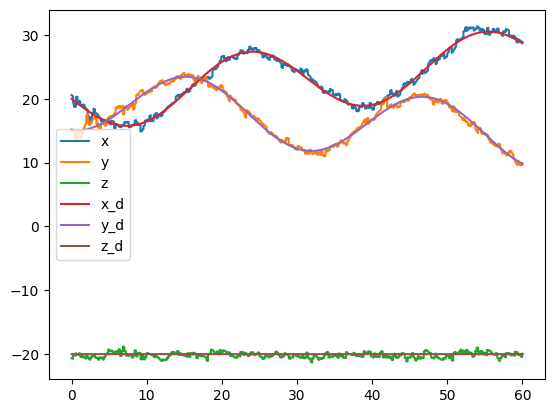

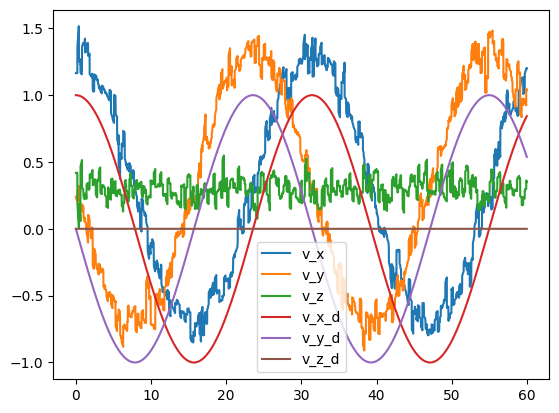

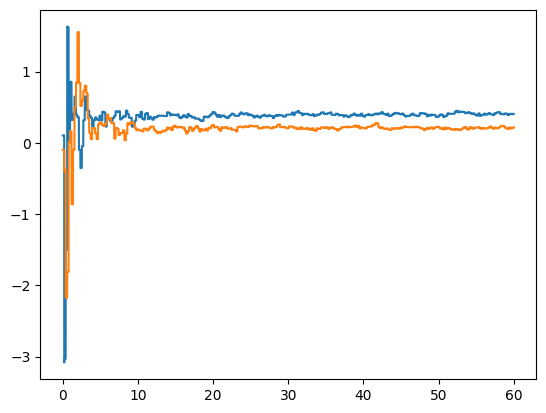

In [85]:
# print error statistics of estimation
print("Error statistics (RMSE):")
print("Relative p:\t", np.sqrt(np.mean((record[:3, :] - rp)**2)))
print("Drone v:\t", np.sqrt(np.mean((record[3:6, :] - vd)**2)))
print("Boat v:\t\t", np.sqrt(np.mean((record[6:8, :] - vb[:2, :])**2)))
print("Drone a:\t", np.sqrt(np.mean((record[8:11, :] - ad)**2)))
print("Bias a:\t\t", np.sqrt(np.mean((record[11:14, :] - ad_bias)**2)))

# plot results
plt.figure()
plt.plot(t, record[0, :], label='x')
plt.plot(t, record[1, :], label='y')
plt.plot(t, record[2, :], label='z')
plt.plot(t, rp[0, :], label='x_d')
plt.plot(t, rp[1, :], label='y_d')
plt.plot(t, rp[2, :], label='z_d')
plt.legend()

plt.figure()
plt.plot(t, record[3, :], label='v_x')
plt.plot(t, record[4, :], label='v_y')
plt.plot(t, record[5, :], label='v_z')
plt.plot(t, vd[0, :], label='v_x_d')
plt.plot(t, vd[1, :], label='v_y_d')
plt.plot(t, vd[2, :], label='v_z_d')
plt.legend()

plt.figure()
plt.plot(t, record[6, :], label='v_x_b')
plt.plot(t, record[7, :], label='v_y_b')
plt.plot(t, record[14, :], label='v_y_b')
plt.plot(t, record[15, :], label='v_y_b')
plt.plot(t, vb[0, :], label='v_x_b_d')
plt.plot(t, vb[1, :], label='v_y_b_d')
plt.ylim(-1, 1)
plt.legend()

plt.figure()
plt.plot(t, record[8, :], label='a_x_d')
plt.plot(t, record[9, :], label='a_y_d')
plt.plot(t, record[10, :], label='a_z_d')
plt.plot(t, ad[0, :], label='a_x_d_d')
plt.plot(t, ad[1, :], label='a_y_d_d')
plt.plot(t, ad[2, :], label='a_z_d_d')
plt.legend()

plt.figure()
plt.plot(t, record[11, :], label='b_a_x')
plt.plot(t, record[12, :], label='b_a_y')
plt.plot(t, record[13, :], label='b_a_z')
plt.plot(t, ad_bias[0, :], label='b_a_x_d')
plt.plot(t, ad_bias[1, :], label='b_a_y_d')
plt.plot(t, ad_bias[2, :], label='b_a_z_d')
plt.legend()

In [427]:
# x = [p,v,a,bias_a,d_bias_a]
# y = [p,a]

A = [[0, 1, 0],
     [0, 0, 1],
     [0, 0, 0]]
A = np.array(A)
# add bias term
A = np.concatenate([A, np.zeros((3, 1))], axis=1)
A = np.concatenate([A, np.zeros((1, 4))], axis=0)
# A[1, 3] = -1
# A[2, 4] = -1
print(A)

C = [[1, 0, 0, 0],
     [0, 0, 1, 1]]
# z = C @ x

# generate trajectory p(t)
end = 60
samples = end*200
t = np.linspace(0, end, samples)
M = .1
p = np.sin(M*t)
v = M*np.cos(M*t)
a = (-M**2)*np.sin(M*t)
a_bias = np.ones(samples)
a_bias[0:samples//4] = 0
VAR = .1
ya = a + a_bias + VAR*np.random.randn(samples)
yp = p + VAR*np.random.randn(samples)

dt = t[1] - t[0]
Ad = la.expm(A*dt)
print(Ad)

a_variance = VAR
p_variance = VAR

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1.      0.005   0.00001 0.     ]
 [0.      1.      0.005   0.     ]
 [0.      0.      1.      0.     ]
 [0.      0.      0.      1.     ]]


In [464]:
# Define the system matrices
F = Ad

H = np.array(C)

Q = np.array([[dt**4/4, dt**3/2, dt**2/2, 0],
              [dt**3/2, dt**2, dt, 0],
              [dt**2/2, dt, 1, 0],
              [0, 0, 0, 1*dt],]) * a_variance

R = np.array([[p_variance, 0],
              [0,  a_variance],])

# Initial state estimate
x_hat = np.array([[0], [1], [0], [0]])

# Initial error covariance
P = np.diag([1, 1, 1, 1]) * 1000

record = np.zeros((len(p), 4))
pos_modulo = int(np.ceil(0.033/dt))
# Kalman Filter loop
for i in range(len(p)):
    # Predict step
    x_hat = F @ x_hat
    P = F @ P @ F.T + Q

    # Position update
    if i % pos_modulo == 0:
        Hp = H[0, :].reshape(1, 4)
        K = P @ Hp.T @ np.linalg.inv(Hp @ P @ Hp.T + R[0, 0])
        x_hat = x_hat + K @ (yp[i] - Hp @ x_hat)
        P = (np.eye(4) - K @ Hp) @ P

    # Acceleration update
    Ha = H[1, :].reshape(1, 4)
    K = P @ Ha.T @ np.linalg.inv(Ha @ P @ Ha.T + R[1, 1])
    x_hat = x_hat + K @ ((ya[i] - x_hat[3]*0) - Ha @ x_hat)
    P = (np.eye(4) - K @ Ha) @ P

    # # mutual update
    # Hm = H
    # K = P @ Hm.T @ np.linalg.inv(Hm @ P @ Hm.T + R)
    # x_hat = x_hat + K @ (np.array([[yp[i]], [ya[i]]]) - Hm @ x_hat)
    # P = (np.eye(4) - K @ Hm) @ P

    record[i, :] = x_hat.T

In [465]:
# print error statistics of estimation
print("Error statistics (RMSE):")
print("p:", np.sqrt(np.mean((record[:, 0] - p)**2)))
print("v:", np.sqrt(np.mean((record[:, 1] - v)**2)))
print("a:", np.sqrt(np.mean((record[:, 2] - a)**2)))

Error statistics (RMSE):
p: 0.03717694528748309
v: 0.13293247448957615
a: 0.21606535920957648


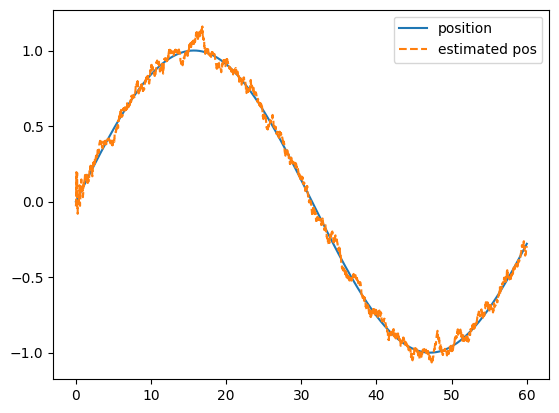

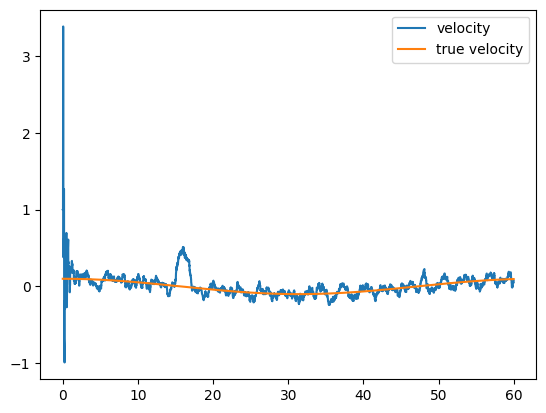

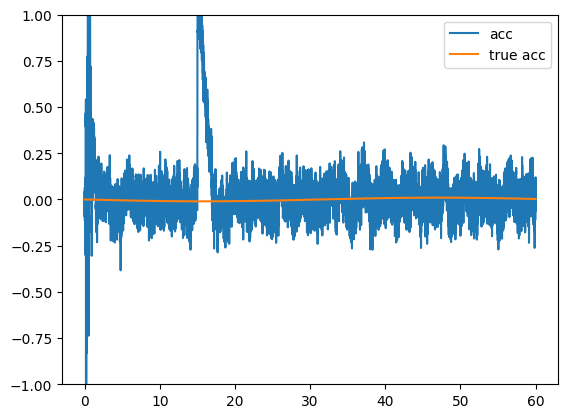

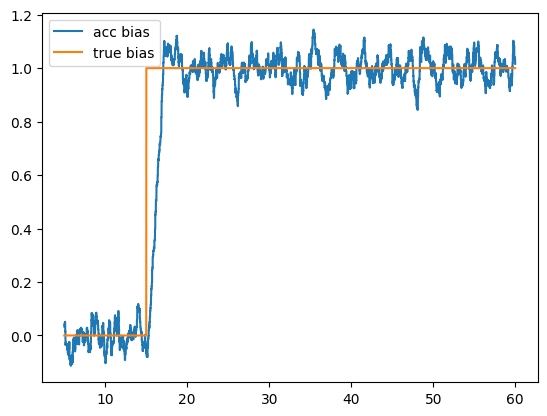

In [466]:
# plt.figure(dpi=200)
plt.plot(t, p, label='position')
plt.plot(t, record[:, 0], label='estimated pos', linestyle='dashed')
# plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
plt.legend()
# velocity
plt.figure()
plt.plot(t, record[:, 1], label='velocity')
plt.plot(t, v, label='true velocity')
plt.legend()
plt.figure()
plt.plot(t, record[:, 2], label='acc')
plt.plot(t, a, label='true acc')
plt.ylim(-1, 1)
plt.legend()
plt.figure()
plt.plot(t[1000:], record[1000:, 3], label='acc bias')
plt.plot(t[1000:], a_bias[1000:], label='true bias')
plt.legend()
plt.show()
# plt.figure()
# plt.plot(t[1000:], record[1000:, 4], label='acc drift')
# plt.legend()
# plt.show()